In [1952]:
from hockey_rink import NHLRink, RinkImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [1954]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows',None)

In [1955]:
img = mpimg.imread(r'C:\Users\kjcs2\GitHub\hockey\hockey_env\rink_template.png')

height, width, _ = img.shape

print(f"Image dimensions: Width = {width}, Height = {height}")
ax.imshow(img, extent=[-100, 100, -42.5, 42.5])

Image dimensions: Width = 2000, Height = 850


In [1956]:
event_data = pd.read_csv("DA_Tutorial24_Event_Data.csv")
ovi_data = event_data
event_data.head()

eventname     outcome              type  compiledgametime  \
0       pass  successful             south          0.733333   
1  reception  successful           regular          1.333333   
2       pass  successful  stretchoffboards          2.566667   
3  reception  successful           regular          3.166667   
4       pass  successful            outlet          5.433333   

         playsection zone manpowersituation  goal  teamid  playerid  \
0      southCenterNZ   nz      evenStrength     0     311    111452   
1      centerPointDZ   dz      evenStrength     0     311        80   
2        westPointDZ   dz      evenStrength     0     311        80   
3  northEastBoardsNZ   nz      evenStrength     0     311    111452   
4        innerSlotDZ   dz      evenStrength     0     315     80264   

   opposingteamgoalieoniceid  xadjcoord  yadjcoord  
0                      80264  -2.316772   9.808823  
1                      80264 -26.457947   6.791176  
2                      80264 -30.481476  30.932352  
3                      80264   3.718521  35.458824  
4                       5152 -81.171463   3.770588

In [1960]:
xG_data = pd.read_csv("DA_Tutorial24_xG_Data.csv")
xG_data.head()

compiledgametime  playerid        xg
0              82.2     56711  0.252678
1              90.9    108339  0.392448
2             154.1        80  0.322435
3             234.5     78625  0.261145
4             236.3     79380  0.252039

In [1961]:
answer_sheet = pd.read_csv("DA_Tutorial24_Answer_Sheet.csv")
answer_sheet.head()

Question Answer
0  Firstname    NaN
1   Lastname    NaN
2         1a    NaN
3         1b    NaN
4         1c    NaN

In [1962]:
event_data.describe()

compiledgametime         goal       teamid      playerid  \
count       1797.000000  1797.000000  1797.000000  1.797000e+03   
mean        1898.000296     0.003895   312.994435  9.606105e+05   
std         1114.682648     0.062309     2.000549  3.974927e+06   
min            0.733333     0.000000   311.000000  8.000000e+01   
25%          969.266660     0.000000   311.000000  7.862500e+04   
50%         1872.600000     0.000000   311.000000  9.453100e+04   
75%         2831.466600     0.000000   315.000000  1.267230e+05   
max         3838.766600     1.000000   315.000000  2.077537e+07   

       opposingteamgoalieoniceid    xadjcoord    yadjcoord  
count                1797.000000  1797.000000  1797.000000  
mean                42812.496383     5.441790     1.937969  
std                 37566.308585    60.811785    26.349383  
min                  5152.000000   -99.392273   -41.997059  
25%                  5152.000000   -50.104050   -22.382353  
50%                 80264.000000    28.865601     3.267647  
75%                 80264.000000    57.525368    26.905884  
max                 80264.000000    99.392273    41.997059

In [1963]:
event_data['minutes'] = round(event_data['compiledgametime']/60,2)
event_data['period'] = np.where(event_data['minutes'] <= 20, 1, np.where(event_data['minutes'] <=40, 2, np.where(event_data['minutes'] <=60, 3, 4)))


In [1964]:


def reverse_adjust_coordinates(row):
    x_adjusted = row['xadjcoord']
    y_adjusted = row['yadjcoord']
    
    team_id = row['teamid']  # Team ID
    period = row['period']    # Period
    
    if team_id == 311: #defend left side twice
        if period in [1,3]: 
            if x_adjusted < 0:
                original_x= x_adjusted #if adjusted is already negative, use it
                original_y = y_adjusted
            else:
                original_x = -x_adjusted #if adjusted is positive, make it negative
                original_y = y_adjusted
        else: #2nd period or OT
            if x_adjusted <0:
                original_x = abs(x_adjusted) #if adjusted is negative, make it positive
                original_y = y_adjusted
            else:
                original_x = x_adjusted #if adjusted is already positive, use it
                original_y = y_adjusted
            
    elif team_id == 315: #defend right side twice
        if period in [1,3]:
            if x_adjusted < 0:
                original_x = abs(x_adjusted) #if adjusted is negative, make it positive
                original_y = abs(y_adjusted)
            else:
                original_x = x_adjusted #if adjusted is positive, use it
                original_y = y_adjusted
        else:#2nd period and OT
            if x_adjusted <0:
                original_x = x_adjusted #if adjusted is negative, use it
                original_y = y_adjusted
            else:
                original_x = -x_adjusted #if adjusted is positive , make it negative
                original_y = y_adjusted
    
    return pd.Series({'xCoord': original_x, 'yCoord': original_y})

# Example usage with a DataFrame
# Assuming you have a DataFrame `df` with adjusted coordinates and additional columns
original_coords = event_data.apply(reverse_adjust_coordinates, axis=1)

# Merge the original coordinates back to the original DataFrame if needed
event_data = event_data.join(original_coords)


In [1965]:
event_data.head()

eventname     outcome              type  compiledgametime  \
0       pass  successful             south          0.733333   
1  reception  successful           regular          1.333333   
2       pass  successful  stretchoffboards          2.566667   
3  reception  successful           regular          3.166667   
4       pass  successful            outlet          5.433333   

         playsection zone manpowersituation  goal  teamid  playerid  \
0      southCenterNZ   nz      evenStrength     0     311    111452   
1      centerPointDZ   dz      evenStrength     0     311        80   
2        westPointDZ   dz      evenStrength     0     311        80   
3  northEastBoardsNZ   nz      evenStrength     0     311    111452   
4        innerSlotDZ   dz      evenStrength     0     315     80264   

   opposingteamgoalieoniceid  xadjcoord  yadjcoord  minutes  period  \
0                      80264  -2.316772   9.808823     0.01       1   
1                      80264 -26.457947   6.791176     0.02       1   
2                      80264 -30.481476  30.932352     0.04       1   
3                      80264   3.718521  35.458824     0.05       1   
4                       5152 -81.171463   3.770588     0.09       1   

      xCoord     yCoord  
0  -2.316772   9.808823  
1 -26.457947   6.791176  
2 -30.481476  30.932352  
3  -3.718521  35.458824  
4  81.171463   3.770588

In [1972]:
shots_data = event_data.query('eventname == "shot" and period == 1')
shots_data = shots_data[['eventname', 'period','teamid','type', 'playsection', 'zone', 'xCoord', 'yCoord','xadjcoord','yadjcoord']]

(-42.0, 42.0)

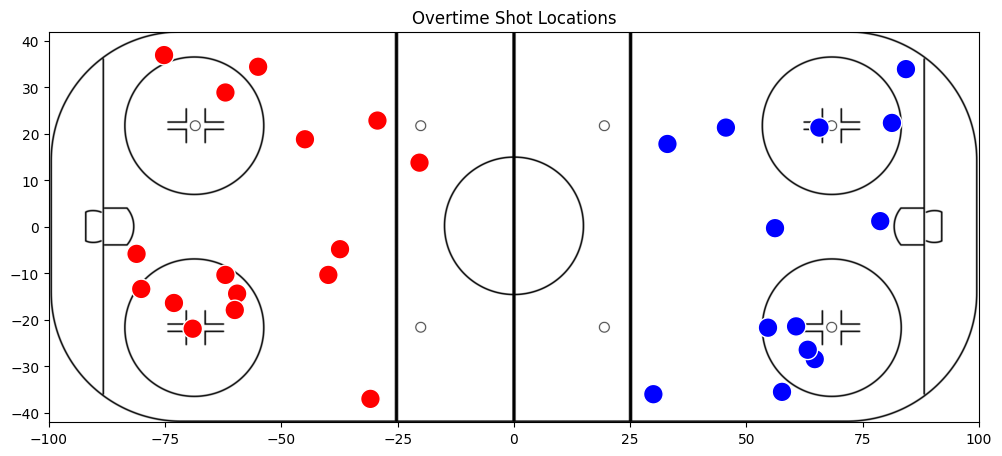

In [1974]:

fig, ax = plt.subplots(figsize=(12, 8))

# Display the image with extent adjusted to match the coordinate system of your data
ax.imshow(img, extent=[-100, 100, -42.5, 42.5])  # Adjust extent based on your data coordinate system


shots_data.loc[:, 'color'] = 'blue'  # Assign blue as the default color
shots_data.loc[shots_data['teamid'] == 311, 'color'] = 'red'

# Plot the data points on top of the image
ax.scatter(shots_data['xCoord'], shots_data['yCoord'],
           s=200, c=shots_data['color'], edgecolor="white")

# Set title
ax.set_title(f"Overtime Shot Locations")

# Set limits to match your data's coordinate system
ax.set_xlim(-100, 100)
ax.set_ylim(-42.5, 42.5)

In [2184]:
score = event_data.query('goal ==1')
score

eventname     outcome     type  compiledgametime       playsection zone  \
20        shot  successful  outside         38.633335  outsideNorthWest   oz   
309       shot  successful     slot        645.066650     eastOuterSlot   oz   
805       shot  successful  outside       1676.600000       centerPoint   oz   
1132      shot  successful     slot       2365.633300         innerSlot   oz   
1203      shot  successful     slot       2504.266600     westOuterSlot   oz   
1271      shot  successful  outside       2648.433300  outsideNorthWest   oz   
1796      shot  successful  outside       3838.766600  outsideNorthWest   oz   

     manpowersituation  goal  teamid  playerid  opposingteamgoalieoniceid  \
20        evenStrength     1     311    109964                      80264   
309       evenStrength     1     315     79380                       5152   
805          powerPlay     1     315     79380                       5152   
1132      evenStrength     1     311    370192                      80264   
1203         powerPlay     1     311    370192                      80264   
1271      evenStrength     1     315     81408                       5152   
1796         powerPlay     1     315     81408                       5152   

      xadjcoord  yadjcoord  minutes  period     xCoord     yCoord  
20    80.157722 -13.326469     0.64       1 -80.157722 -13.326469  
309   65.687363  21.373528    10.75       1  65.687363  21.373528  
805   46.971462  10.814705    27.94       2 -46.971462  10.814705  
1132  77.262863  -1.258823    39.43       2  77.262863  -1.258823  
1203  68.087128 -12.823528    41.74       3 -68.087128 -12.823528  
1271  87.313828  -8.299999    44.14       3  87.313828  -8.299999  
1796  62.562599 -25.900000    63.98       4 -62.562599 -25.900000

In [1976]:
score = score.groupby('teamid')['goal'].count()
score

teamid
311    3
315    4
Name: goal, dtype: int64

In [1977]:
overtime = event_data.query('period == 4')
overtime.head()

eventname     outcome              type  compiledgametime  \
1669       pass  successful             south         3602.6000   
1670  reception  successful           regular         3603.4000   
1671       pass  successful      d2doffboards         3610.8000   
1672  reception  successful           regular         3612.6000   
1673       pass  successful  stretchoffboards         3614.5334   

             playsection zone manpowersituation  goal  teamid  playerid  \
1669       southCenterNZ   nz      evenStrength     0     315     80518   
1670       centerPointDZ   dz      evenStrength     0     315     79380   
1671  outsideNorthWestDZ   dz      evenStrength     0     315     79380   
1672  outsideNorthWestDZ   dz      evenStrength     0     315     80518   
1673  outsideNorthWestDZ   dz      evenStrength     0     315     80518   

      opposingteamgoalieoniceid  xadjcoord  yadjcoord  minutes  period  \
1669                       5152  -1.318748  -2.764706    60.04       4   
1670                       5152 -33.506989  13.329412    60.06       4   
1671                       5152 -72.736404  40.488235    60.18       4   
1672                       5152 -98.386398   6.791176    60.21       4   
1673                       5152 -85.812866  17.352942    60.24       4   

         xCoord     yCoord  
1669  -1.318748  -2.764706  
1670 -33.506989  13.329412  
1671 -72.736404  40.488235  
1672 -98.386398   6.791176  
1673 -85.812866  17.352942

In [1978]:
ot_blocked = overtime[overtime['type'].str.contains('blocked')]
ot_blocked_shots = ot_blocked.query('eventname == "shot"')
# Count occurrences of 'pass' in the 'action' column of the filtered DataFrame
#blocked_shots = (ot_blocked['eventname'] == 'shot').count()
#blocked_shots
ot_blocked_shots.head()

eventname outcome            type  compiledgametime    playsection zone  \
1751      shot  failed  outsideblocked         3742.1000      westPoint   oz   
1781      shot  failed     slotblocked         3821.4333  westOuterSlot   oz   
1788      shot  failed     slotblocked         3829.3000  westOuterSlot   oz   

     manpowersituation  goal  teamid  playerid  opposingteamgoalieoniceid  \
1751         powerPlay     0     315     81408                       5152   
1781         powerPlay     0     315     81408                       5152   
1788         powerPlay     0     315     81408                       5152   

      xadjcoord  yadjcoord  minutes  period     xCoord     yCoord  
1751  38.924404 -35.958824    62.37       4 -38.924404 -35.958824  
1781  60.550873 -21.876472    63.69       4 -60.550873 -21.876472  
1788  59.544991 -20.367645    63.82       4 -59.544991 -20.367645

In [1979]:
winning_team_shots = overtime.query('teamid == 315 and eventname == "shot"')
winning_team_shots = winning_team_shots[['goal', 'xCoord', 'yCoord' ]]
winning_team_shots.head()

goal     xCoord     yCoord
1681     0 -60.543015 -21.373528
1690     0 -61.548901 -21.879400
1709     0 -56.527344   7.294117
1714     0 -64.574402  15.341177
1725     0 -59.042049 -19.864708

(-42.0, 42.0)

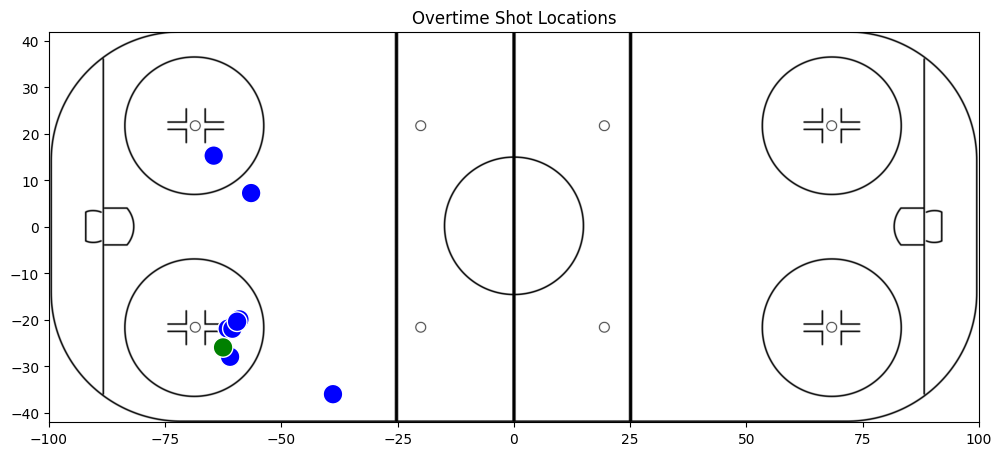

In [1980]:
#OT Shot Locations
fig, ax = plt.subplots(figsize=(12, 8))

# Display the image with extent adjusted to match the coordinate system of your data
ax.imshow(img, extent=[-100, 100, -42, 42])  # Adjust extent based on your data coordinate system

# Map the triCode values to colors
winning_team_shots['color'] = 'blue'  # Assign blue as the default color
winning_team_shots.loc[winning_team_shots['goal'] == 1, 'color'] = 'green'  # Update shots marked as "Goals" with green color

# Plot the data points on top of the image
ax.scatter(winning_team_shots['xCoord'], winning_team_shots['yCoord'],
           s=200, c=winning_team_shots['color'], edgecolor="white")

# Set title
ax.set_title(f"Overtime Shot Locations")

# Set limits to match your data's coordinate system
ax.set_xlim(-100, 100)
ax.set_ylim(-42, 42)


In [1981]:
player_81408 = event_data.query('playerid == 81408')
player_81408.head()

eventname     outcome            type  compiledgametime  \
11   reception  successful         regular          19.00000   
55        pass  successful  northoffboards         141.96666   
76   reception  successful         regular         171.30000   
77        pass  successful            rush         171.96666   
110  reception  successful         regular         236.90000   

           playsection zone manpowersituation  goal  teamid  playerid  \
11   southWestBoardsNZ   nz      evenStrength     0     315     81408   
55    outsideNorthEast   oz      evenStrength     0     315     81408   
76   northEastBoardsNZ   nz      evenStrength     0     315     81408   
77           eastPoint   oz      evenStrength     0     315     81408   
110   outsideNorthWest   oz         powerPlay     0     315     81408   

     opposingteamgoalieoniceid  xadjcoord  yadjcoord  minutes  period  \
11                        5152 -15.789108 -36.464706     0.32       1   
55                        5152  95.863831  20.870590     2.37       1   
76                        5152  16.902069  34.952942     2.86       1   
77                        5152  34.505005  35.958824     2.87       1   
110                       5152  59.659927 -24.394117     3.95       1   

        xCoord     yCoord  
11   15.789108  36.464706  
55   95.863831  20.870590  
76   16.902069  34.952942  
77   34.505005  35.958824  
110  59.659927 -24.394117

In [1983]:
shot_attempts = player_81408.query('eventname == "shot"')
pp_shot_attempts = shot_attempts.groupby('manpowersituation')['eventname'].count()
pp_shot_attempts

manpowersituation
evenStrength     2
powerPlay       15
Name: eventname, dtype: int64

In [1984]:
pp_attempts = shot_attempts.query('manpowersituation == "powerPlay"')
pp_attempts = pp_attempts[['xCoord', 'yCoord', 'xadjcoord', 'yadjcoord','period', 'teamid' ]]

In [1985]:
pp_attempts.head()

xCoord     yCoord  xadjcoord  yadjcoord  period  teamid
111  60.665802 -21.376471  60.665802 -21.376471       1     315
138  57.640305 -35.458824  57.640305 -35.458824       1     315
411  54.630508 -21.657959  54.630508 -21.657959       1     315
458  63.172653 -26.405882  63.172653 -26.405882       1     315
832 -68.597931 -19.864708  68.597931 -19.864708       2     315

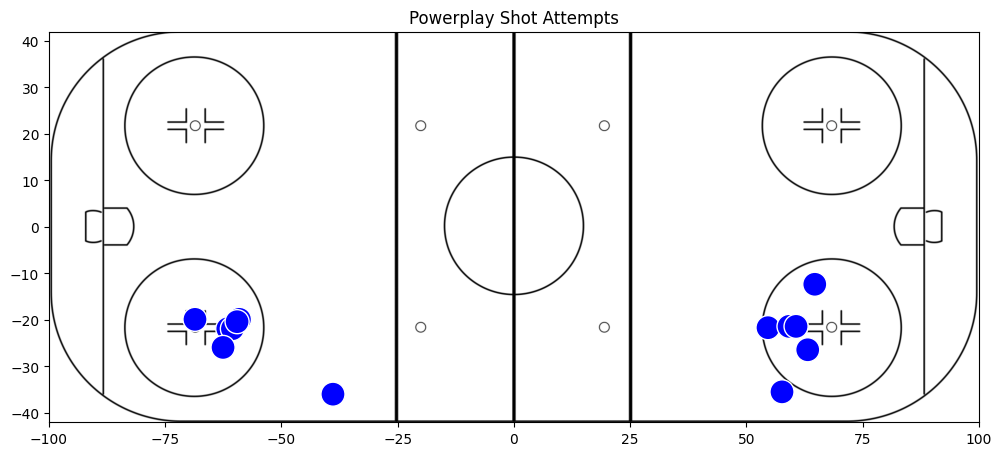

In [1986]:
#Power Play shot attempts for the full game


fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(img, extent=[-100, 100, -42.5, 42.5]) 

# Map the triCode values to colors
pp_attempts['color'] = 'blue' 
# Plot the data points on top of the image
ax.scatter(pp_attempts['xCoord'], pp_attempts['yCoord'],
           s=300, c=pp_attempts['color'], edgecolor="white")


# Set limits to match your data's coordinate system
ax.set_xlim(-100, 100)
ax.set_ylim(-42.5, 42.5)
ax.set_title(f"Powerplay Shot Attempts")

plt.show()



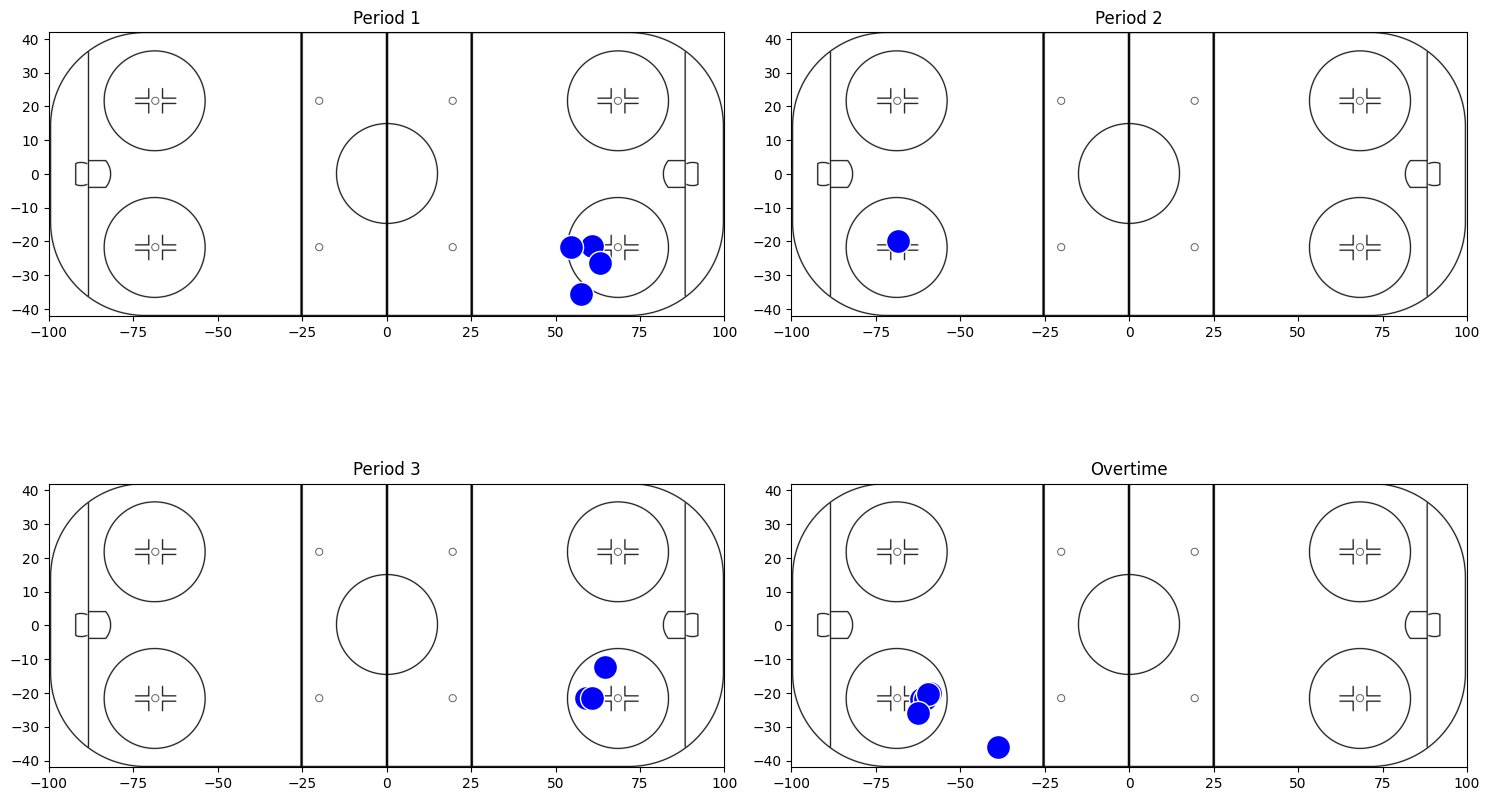

In [1987]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust size as needed

# List of periods and titles for each subplot
periods = [1, 2, 3, 4]
titles = ["Period 1", "Period 2", "Period 3", "Overtime"]

for ax, period, title in zip(axs.flatten(), periods, titles):
    # Filter data for the current period
    period_data = pp_attempts[pp_attempts['period'] == period]
    
    # Plot background image
    ax.imshow(img, extent=[-100, 100, -42.5, 42.5])
    
    # Plot scatter points
    ax.scatter(period_data['xCoord'], period_data['yCoord'],
               s=300, c='blue', edgecolor="white")
    
    # Set limits and title
    ax.set_xlim(-100, 100)
    ax.set_ylim(-42.5, 42.5)
    ax.set_title(title)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [2000]:
pp_attempts.head()

xCoord     yCoord  xadjcoord  yadjcoord  period  teamid color
111  60.665802 -21.376471  60.665802 -21.376471       1     315  blue
138  57.640305 -35.458824  57.640305 -35.458824       1     315  blue
411  54.630508 -21.657959  54.630508 -21.657959       1     315  blue
458  63.172653 -26.405882  63.172653 -26.405882       1     315  blue
832 -68.597931 -19.864708  68.597931 -19.864708       2     315  blue

In [2001]:
ovi_data.head()

eventname     outcome              type  compiledgametime  \
0       pass  successful             south          0.733333   
1  reception  successful           regular          1.333333   
2       pass  successful  stretchoffboards          2.566667   
3  reception  successful           regular          3.166667   
4       pass  successful            outlet          5.433333   

         playsection zone manpowersituation  goal  teamid  playerid  \
0      southCenterNZ   nz      evenStrength     0     311    111452   
1      centerPointDZ   dz      evenStrength     0     311        80   
2        westPointDZ   dz      evenStrength     0     311        80   
3  northEastBoardsNZ   nz      evenStrength     0     311    111452   
4        innerSlotDZ   dz      evenStrength     0     315     80264   

   opposingteamgoalieoniceid  xadjcoord  yadjcoord  minutes  period  
0                      80264  -2.316772   9.808823     0.01       1  
1                      80264 -26.457947   6.791176     0.02       1  
2                      80264 -30.481476  30.932352     0.04       1  
3                      80264   3.718521  35.458824     0.05       1  
4                       5152 -81.171463   3.770588     0.09       1

In [2002]:
#If it is the case that the player is Ovi, to ensure that the y coordinates are properly unfolded:

def reverse_adjust_coordinates(row):
    x_adjusted = row['xadjcoord']
    y_adjusted = row['yadjcoord']
    
    team_id = row['teamid']  # Team ID
    period = row['period']    # Period
            
    if period in [1,3]:
        if x_adjusted < 0:
            original_x = abs(x_adjusted) #if adjusted is negative, make it positive
            original_y = abs(y_adjusted)
        else:
            original_x = x_adjusted #if adjusted is positive, use it
            original_y = abs(y_adjusted)
    else:#2nd period and OT
        if x_adjusted <0:
            original_x = x_adjusted #if adjusted is negative, use it
            original_y = y_adjusted
        else:
            original_x = -x_adjusted #if adjusted is positive , make it negative
            original_y = y_adjusted
    
    return pd.Series({'ovixCoords': original_x, 'oviyCoords': original_y})

# Example usage with a DataFrame
# Assuming you have a DataFrame `df` with adjusted coordinates and additional columns
original_coords = pp_attempts.apply(reverse_adjust_coordinates, axis=1)

# Merge the original coordinates back to the original DataFrame if needed
ovi_pp = pp_attempts.join(original_coords)


In [2003]:
ovi_pp.head()

xCoord     yCoord  xadjcoord  yadjcoord  period  teamid color  \
111  60.665802 -21.376471  60.665802 -21.376471       1     315  blue   
138  57.640305 -35.458824  57.640305 -35.458824       1     315  blue   
411  54.630508 -21.657959  54.630508 -21.657959       1     315  blue   
458  63.172653 -26.405882  63.172653 -26.405882       1     315  blue   
832 -68.597931 -19.864708  68.597931 -19.864708       2     315  blue   

     ovixCoords  oviyCoords  
111   60.665802   21.376471  
138   57.640305   35.458824  
411   54.630508   21.657959  
458   63.172653   26.405882  
832  -68.597931  -19.864708

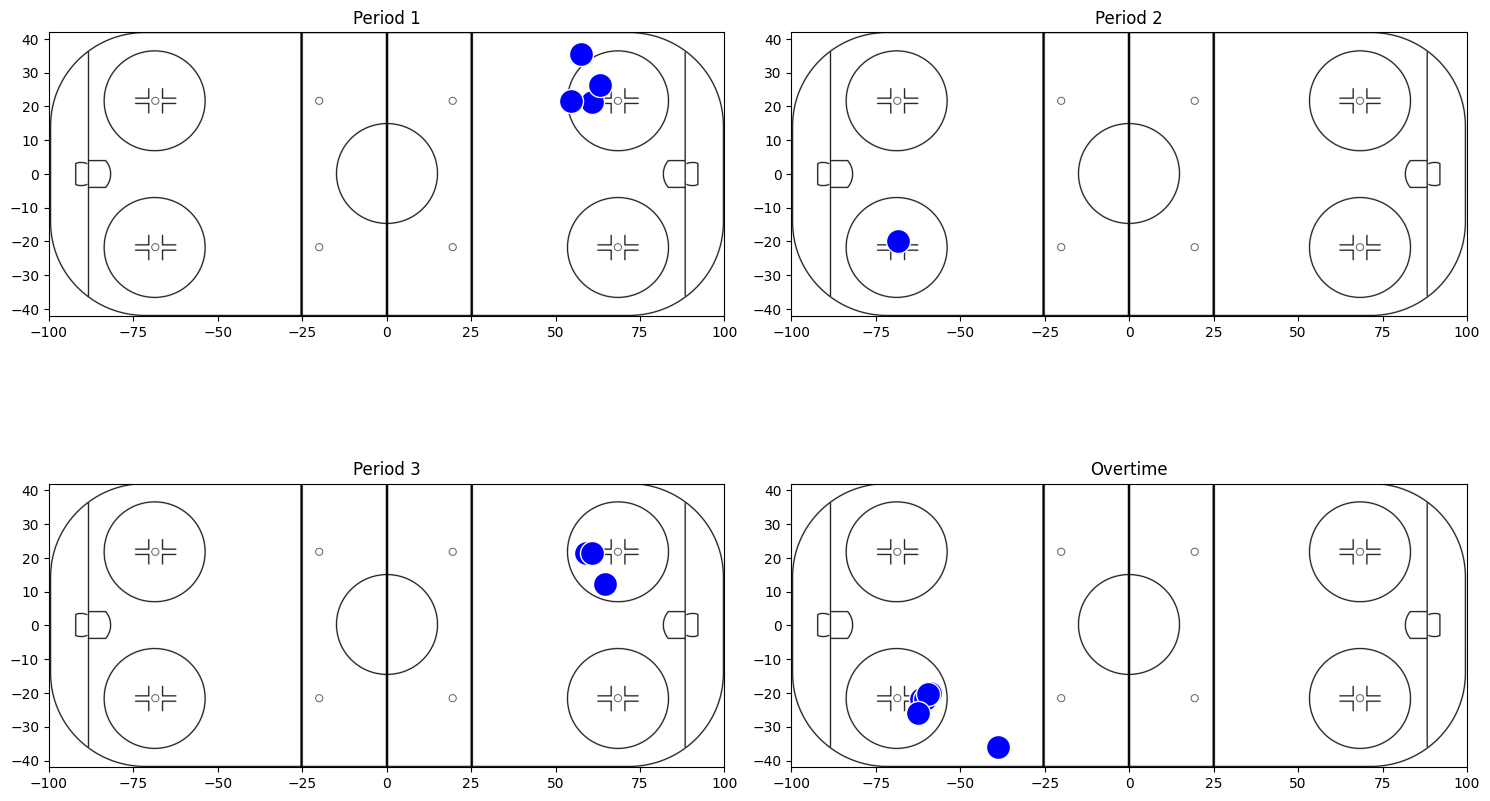

In [2004]:



# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust size as needed

# List of periods and titles for each subplot
periods = [1, 2, 3, 4]
titles = ["Period 1", "Period 2", "Period 3", "Overtime"]

for ax, period, title in zip(axs.flatten(), periods, titles):
    # Filter data for the current period
    period_data = ovi_pp[ovi_pp['period'] == period]
    
    # Plot background image
    ax.imshow(img, extent=[-100, 100, -42.5, 42.5])
    
    # Plot scatter points
    ax.scatter(period_data['ovixCoords'], period_data['oviyCoords'],
               s=300, c='blue', edgecolor="white")
    
    # Set limits and title
    ax.set_xlim(-100, 100)
    ax.set_ylim(-42.5, 42.5)
    ax.set_title(title)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [2005]:
#team 315 even strength passing
team_315_passes = event_data.query('teamid == 315 and eventname == "pass" and manpowersituation == "evenStrength"')
team_315_passes['success'] = np.where(team_315_passes['outcome'] == "successful", "success", "failed")


team_315_passes=team_315_passes.groupby(['eventname', 'zone','success'])['outcome'].count()

team_315_passes = pd.DataFrame(team_315_passes).reset_index()
team_315_passes.head()

C:\Users\kjcs2\AppData\Local\Temp\ipykernel_10948\2216007909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_315_passes['success'] = np.where(team_315_passes['outcome'] == "successful", "success", "failed")


eventname zone  success  outcome
0      pass   dz   failed       37
1      pass   dz  success      115
2      pass   nz   failed       12
3      pass   nz  success       28
4      pass   oz   failed       40

In [2012]:
team_315_passes = team_315_passes.pivot(index='zone', columns='success', values='outcome')
team_315_passes = team_315_passes.fillna(0)

In [2014]:

team_315_passes=team_315_passes.reset_index()
team_315_passes

success zone  failed  success
0         dz      37      115
1         nz      12       28
2         oz      40       43

In [2015]:
team_315_passes['total_attempts'] = team_315_passes['failed']+ team_315_passes['success']
team_315_passes['pass_rate'] = team_315_passes['success']/team_315_passes['total_attempts']
team_315_passes['pass_rate_pct'] = round(team_315_passes['pass_rate']*100,2)
team_315_passes

success zone  failed  success  total_attempts  pass_rate  pass_rate_pct
0         dz      37      115             152   0.756579          75.66
1         nz      12       28              40   0.700000          70.00
2         oz      40       43              83   0.518072          51.81

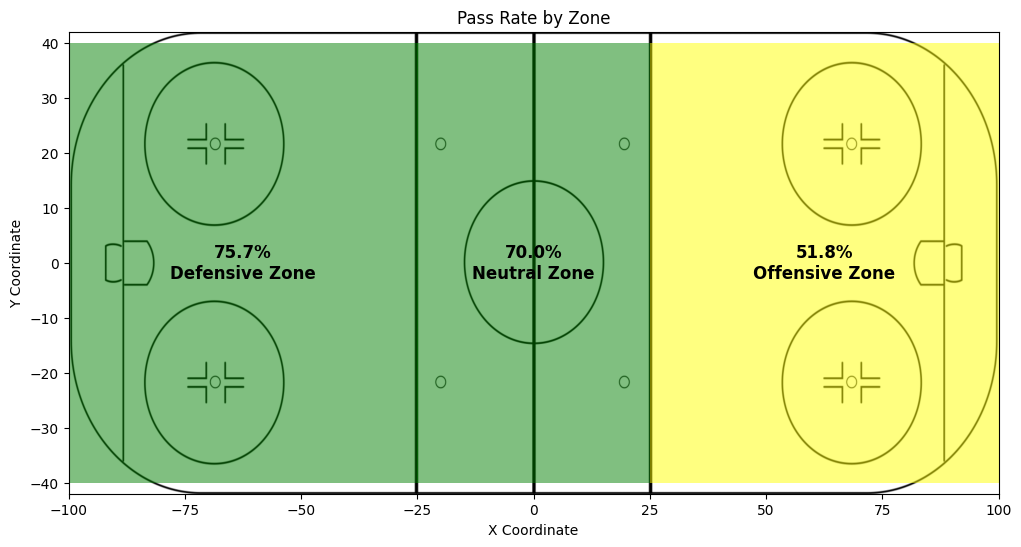

In [2016]:
# Load the rink image
img = mpimg.imread(r'C:\Users\kjcs2\GitHub\hockey\hockey_env\rink_template.png')

# Define the extent of the image on the rink
extent = [-100, 100, -42, 42]

# Define zone extents
zone_ranges = {
    'dz': {'x': (-100, -25), 'y': (-40, 40)},
    'nz': {'x': (-25, 25), 'y': (-40, 40)},
    'oz': {'x': (25, 100), 'y': (-40, 40)}
}

zone_names = {
    'dz': 'Defensive Zone',
    'nz': 'Neutral Zone',
    'oz': 'Offensive Zone'
}


# Define the colormap and boundaries
cmap = ListedColormap(['red', 'yellow', 'green'])
bounds = [0, .45, .60, 1.00]
norm = BoundaryNorm(bounds, cmap.N)


# Create a blank image to overlay heatmaps
fig, ax = plt.subplots(figsize=(12, 6))

# Display the rink image
ax.imshow(img, extent=extent, aspect='auto')

# Plot heatmaps for each zone
# Plot background color rectangles for each zone based on pass rate
for _, row in team_315_passes.iterrows():
    zone = row['zone']
    pass_rate_pct = row['pass_rate_pct']
    pass_rate = row['pass_rate']

    # Determine zone extents
    zone_extent = zone_ranges[zone]

    # Create a masked array for background color
    gradient = np.full((2, 256), pass_rate)
    im = ax.imshow(gradient, aspect='auto', cmap=cmap, norm=norm,
                   extent=[zone_extent['x'][0], zone_extent['x'][1],
                           zone_extent['y'][0], zone_extent['y'][1]],
                   alpha=0.5)

    # Annotate the pass rate in the zone
    cx = (zone_extent['x'][0] + zone_extent['x'][1]) / 2
    cy = (zone_extent['y'][0] + zone_extent['y'][1]) / 2
    zone_full_name = zone_names[zone]  # Get the full zone name
    ax.text(cx, cy, f'{pass_rate_pct:.1f}%\n{zone_full_name}', 
            color='black', ha='center', va='center', 
            fontsize=12, fontweight='bold')
# Set limits and labels
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_title('Pass Rate by Zone')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

plt.show()


In [2017]:
event_data.head()

eventname     outcome              type  compiledgametime  \
0       pass  successful             south          0.733333   
1  reception  successful           regular          1.333333   
2       pass  successful  stretchoffboards          2.566667   
3  reception  successful           regular          3.166667   
4       pass  successful            outlet          5.433333   

         playsection zone manpowersituation  goal  teamid  playerid  \
0      southCenterNZ   nz      evenStrength     0     311    111452   
1      centerPointDZ   dz      evenStrength     0     311        80   
2        westPointDZ   dz      evenStrength     0     311        80   
3  northEastBoardsNZ   nz      evenStrength     0     311    111452   
4        innerSlotDZ   dz      evenStrength     0     315     80264   

   opposingteamgoalieoniceid  xadjcoord  yadjcoord  minutes  period  \
0                      80264  -2.316772   9.808823     0.01       1   
1                      80264 -26.457947   6.791176     0.02       1   
2                      80264 -30.481476  30.932352     0.04       1   
3                      80264   3.718521  35.458824     0.05       1   
4                       5152 -81.171463   3.770588     0.09       1   

      xCoord     yCoord  
0  -2.316772   9.808823  
1 -26.457947   6.791176  
2 -30.481476  30.932352  
3  -3.718521  35.458824  
4  81.171463   3.770588

In [2018]:
#teamid 311's all strengths slot save percentage? (The slot includes innerSlot, westOuterSlot, & eastOuterSlot

team_311_saves = event_data.query('teamid == 311 and eventname == "shot" or eventname == "pass"')

team_311_saves = team_311_saves[team_311_saves['playsection'].str.contains('Slot')]
#team_311_saves = team_311_saves[team_311_saves['type'].str.contains('blocked')]
team_311_saves

eventname     outcome             type  compiledgametime  \
4         pass  successful           outlet          5.433333   
65        pass  successful           outlet        154.100000   
73        pass  successful              d2d        168.700000   
75        pass  successful          stretch        170.366670   
91        pass  successful           outlet        201.066670   
187       pass  successful             slot        376.566680   
189       shot      failed      slotblocked        377.300000   
223       pass  successful           outlet        430.666660   
235       pass      failed              d2d        469.566680   
279       pass  successful           outlet        561.300000   
290       pass  successful   ozentrystretch        597.166700   
355       pass  successful              d2d        756.066650   
382       shot  successful             slot        827.566650   
444       pass  successful           outlet        960.500000   
506       pass  successful            south       1058.866700   
522       shot      failed      slotblocked       1072.433300   
525       shot  successful             slot       1079.000000   
527       pass  successful            south       1084.100000   
552       shot      failed             slot       1120.566700   
554       pass  successful             slot       1123.966700   
556       shot      failed      slotblocked       1124.633300   
559       pass      failed             slot       1131.033300   
570       pass  successful            south       1153.100000   
591       shot      failed             slot       1208.200000   
625       pass  successful            south       1283.466700   
635       pass      failed           outlet       1300.266700   
637       pass      failed           outlet       1313.000000   
663       shot  successful             slot       1369.600000   
666       pass  successful   southoffboards       1378.166600   
679       pass  successful            south       1413.766700   
693       shot      failed             slot       1427.666600   
713       shot      failed             slot       1469.566700   
718       pass      failed             slot       1477.933300   
736       pass      failed   northoffboards       1514.333400   
743       pass      failed           outlet       1546.766700   
745       pass  successful  outletoffboards       1549.733300   
801       pass  successful            south       1672.366700   
809       pass  successful            north       1697.000000   
839       pass  successful            south       1744.300000   
935       shot      failed      slotblocked       1955.066700   
956       shot      failed             slot       2007.266700   
957       shot      failed             slot       2007.600000   
984       pass  successful           outlet       2085.733400   
998       pass  successful             slot       2106.433300   
1000      pass  successful            south       2107.033400   
1005      pass  successful            south       2120.300000   
1014      pass  successful             slot       2127.333300   
1016      shot      failed      slotblocked       2128.600000   
1031      pass  successful             slot       2160.533400   
1033      pass      failed         eastwest       2160.700000   
1050      shot  successful             slot       2181.400000   
1053      pass  successful           outlet       2198.000000   
1069      pass  successful            south       2236.166700   
1081      pass      failed           outlet       2257.100000   
1092      pass  successful           outlet       2288.400000   
1099      pass      failed  outletoffboards       2301.666700   
1110      pass  successful            south       2320.100000   
1112      shot  successful             slot       2323.400000   
1132      shot  successful             slot       2365.633300   
1137      shot  successful          outside       2371.266600   
1138      pass  successful           out

In [2021]:

team_311_saves['success'] = np.where(team_311_saves['outcome'] == "successful", "success", "failed")


team_311_saves=team_311_saves.groupby(['eventname','success'])['outcome'].count()

team_311_saves = pd.DataFrame(team_311_saves).reset_index()
team_311_saves.head()

eventname  success  outcome
0      pass   failed       17
1      pass  success       63
2      shot   failed       14
3      shot  success       14

In [2022]:
team_311_saves = team_311_saves.pivot(index='eventname', columns='success', values='outcome')
team_311_saves = team_311_saves.fillna(0)

In [2023]:

team_311_saves=team_311_saves.reset_index()
team_311_saves

success eventname  failed  success
0            pass      17       63
1            shot      14       14

In [2030]:
team_311_saves['total_attempts'] = team_311_saves['failed']+ team_311_saves['success']
team_311_saves['stop_rate'] = team_311_saves['failed']/team_311_saves['total_attempts']
team_311_saves['stop_rate_pct'] = round(team_311_saves['stop_rate']*100,2)
team_311_saves

success eventname  failed  success  total_attempts  stop_rate  stop_rate_pct
0            pass      17       63              80     0.2125          21.25
1            shot      14       14              28     0.5000          50.00

In [2031]:
#315 sog

shots_315 = event_data.query('teamid == 315 and eventname == "shot" and playsection == "outsideNorthWest"')
shots_315 = shots_315[['eventname', 'outcome', 'goal', 'xCoord', 'yCoord']]
shots_315

eventname     outcome  goal     xCoord     yCoord
138       shot      failed     0  57.640305 -35.458824
405       shot      failed     0  64.681473 -28.417646
458       shot      failed     0  63.172653 -26.405882
1249      shot  successful     0  61.168747 -31.938236
1271      shot  successful     1  87.313828  -8.299999
1730      shot  successful     0 -61.053814 -27.911766
1796      shot  successful     1 -62.562599 -25.900000

In [2034]:
#center net
net_x = 89
net_y = 0

def calculate_distance(x, y, net_x=net_x, net_y=net_y):
    return math.sqrt((x - net_x)**2 + (y - net_y)**2)

# Apply the function to each row and create a new column
shots_315['distance'] = shots_315.apply(lambda row: calculate_distance(row['xCoord'], row['yCoord']), axis=1)
shots_315

eventname     outcome  goal     xCoord     yCoord    distance
138       shot      failed     0  57.640305 -35.458824   47.336653
405       shot      failed     0  64.681473 -28.417646   37.402585
458       shot      failed     0  63.172653 -26.405882   36.936736
1249      shot  successful     0  61.168747 -31.938236   42.363069
1271      shot  successful     1  87.313828  -8.299999    8.469543
1730      shot  successful     0 -61.053814 -27.911766  152.627697
1796      shot  successful     1 -62.562599 -25.900000  153.759655

In [2035]:
#all shot attempts
round(shots_315['distance'].mean(),2)

np.float64(68.41)

In [2036]:
#all shots on goal
sog_315 = shots_315.query('outcome == "successful"')
round(sog_315['distance'].mean(),2)

np.float64(89.3)

In [2037]:
xG_data.head()

compiledgametime  playerid        xg
0              82.2     56711  0.252678
1              90.9    108339  0.392448
2             154.1        80  0.322435
3             234.5     78625  0.261145
4             236.3     79380  0.252039

In [2038]:
gsaExpected = event_data.query('playsection == "outsideNorthWest"')
gsaExpected = gsaExpected[['eventname','goal', 'playerid', 'compiledgametime','type','teamid']]

In [2039]:
gsaExpected

eventname  goal  playerid  compiledgametime            type  teamid
14         pass     0    109964         29.566668           south     311
18         pass     0    370192         38.033333           south     311
19    reception     0    109964         38.400000         regular     311
20         shot     1    109964         38.633335         outside     311
23    reception     0    126723         50.500000         regular     315
32         pass     0     56711         76.466670            slot     315
35         pass     0    179172         85.733330  northoffboards     315
50         pass     0    109964        115.966670            slot     311
56    reception     0     10534        144.000000         regular     315
57         pass     0     10534        144.166670           south     315
110   reception     0     81408        236.900000         regular     315
114        pass     0     82048        257.766660  northoffboards     315
138        shot     0     81408        306.900000  outsideblocked     315
141        pass     0    111452        315.633330           south     311
166        pass     0    111452        354.200000  northoffboards     311
173   reception     0    111452        361.933320         regular     311
174        pass     0    111452        362.800000           south     311
178        pass     0    111452        366.100000            slot     311
204        pass     0   2546838        412.100000  southoffboards     311
266        pass     0    109964        533.333300           south     311
306        pass     0     81408        637.066650            slot     315
308        pass     0     81408        642.900000            slot     315
317        pass     0    108339        668.466700            none     311
337        pass     0    126723        712.433350  northoffboards     315
338        pass     0    126723        715.333300            slot     315
339        pass     0     80518        717.800000  northoffboards     315
405        shot     0    400162        881.266660  outsideblocked     315
407   reception     0    110856        887.866640         regular     315
408        pass     0    110856        888.666700  northoffboards     315
412        pass     0     80518        899.133360  northoffboards     315
422   reception     0     81408        925.033300         ozentry     315
423        pass     0     81408        925.800000  northoffboards     315
457   reception     0     81408        981.166700         regular     315
458        shot     0     81408        981.266660         outside     315
514        pass     0    109964       1065.933300            slot     311
516        pass     0    111452       1067.966700           south     311
519   reception     0    111452       1071.200000         regular     311
520        pass     0    111452       1071.900000            slot     311
524   reception     0    111452       1077.866700         regular     311
526        pass     0    111452       1081.666600           north     311
565        pass     0    370192       1148.333400           south     311
583        pass     0    110409       1197.266700           south     311
605        pass     0     94531       1249.166600  southoffboards     311
608        pass     0    237838       1256.733300            slot     311
621   reception     0    237838       1275.100000         regular     311
622        pass     0    237838       1276.766700  southoffboards     311
659        pass     0    112050       1368.200000           south     311
671        pass     0     78625       1395.533300  northoffboards     315
714        pass     0    109964       1473.266700           north     311
715   reception     0    112050       1474.266700         regular     311
716        pass     0    112050       1475.866700            slot     311
762        pass     0     10534       1591.700000           south     315
775        pass     0     81408       1605.766700            slot     315
777       

In [2046]:
expected_goals = pd.merge(gsaExpected, xG_data, on=['compiledgametime', 'playerid'], how='inner')

all_data = pd.merge(gsaExpected, xG_data, on=['compiledgametime', 'playerid'], how='inner')
all_data

eventname  goal  playerid  compiledgametime            type  teamid  \
0       shot     1    109964         38.633335         outside     311   
1       shot     0     81408        306.900000  outsideblocked     315   
2       pass     0    111452        354.200000  northoffboards     311   
3       shot     0    400162        881.266660  outsideblocked     315   
4       shot     0     81408        981.266660         outside     315   
5       shot     0    111452       1885.233300  outsideblocked     311   
6       shot     0     94531       2027.233300         outside     311   
7       shot     0    370192       2125.233400         outside     311   
8       shot     0     56711       2590.066700         outside     315   
9       shot     1     81408       2648.433300         outside     315   
10      shot     0     94531       3223.400000  outsideblocked     311   
11      shot     0   1731661       3401.000000         outside     311   
12      shot     0    370192       3416.133300         outside     311   
13      shot     0    110409       3517.400000         outside     311   
14      shot     0     79380       3705.800000         outside     315   
15      shot     1     81408       3838.766600         outside     315   

          xg  
0   0.072824  
1   0.010496  
2   0.510810  
3   0.011721  
4   0.047728  
5   0.017890  
6   0.016057  
7   0.032598  
8   0.010988  
9   0.312032  
10  0.005776  
11  0.011652  
12  0.022434  
13  0.190465  
14  0.100543  
15  0.050910

In [2048]:
expected_goals

eventname  goal  playerid  compiledgametime            type  teamid  \
0       shot     1    109964         38.633335         outside     311   
1       shot     0     81408        306.900000  outsideblocked     315   
2       pass     0    111452        354.200000  northoffboards     311   
3       shot     0    400162        881.266660  outsideblocked     315   
4       shot     0     81408        981.266660         outside     315   
5       shot     0    111452       1885.233300  outsideblocked     311   
6       shot     0     94531       2027.233300         outside     311   
7       shot     0    370192       2125.233400         outside     311   
8       shot     0     56711       2590.066700         outside     315   
9       shot     1     81408       2648.433300         outside     315   
10      shot     0     94531       3223.400000  outsideblocked     311   
11      shot     0   1731661       3401.000000         outside     311   
12      shot     0    370192       3416.133300         outside     311   
13      shot     0    110409       3517.400000         outside     311   
14      shot     0     79380       3705.800000         outside     315   
15      shot     1     81408       3838.766600         outside     315   

          xg  
0   0.072824  
1   0.010496  
2   0.510810  
3   0.011721  
4   0.047728  
5   0.017890  
6   0.016057  
7   0.032598  
8   0.010988  
9   0.312032  
10  0.005776  
11  0.011652  
12  0.022434  
13  0.190465  
14  0.100543  
15  0.050910

In [2049]:
expected_goals = expected_goals[['goal','xg']]


In [2052]:


total_expected  = expected_goals['xg'].sum()
total_allowed = expected_goals['goal'].sum()

GSAx = total_expected-total_allowed
print(total_expected)
print(total_allowed)
print(GSAx)

1.424924397527426
3
-1.575075602472574


In [2054]:
event_data.head()

eventname     outcome              type  compiledgametime  \
0       pass  successful             south          0.733333   
1  reception  successful           regular          1.333333   
2       pass  successful  stretchoffboards          2.566667   
3  reception  successful           regular          3.166667   
4       pass  successful            outlet          5.433333   

         playsection zone manpowersituation  goal  teamid  playerid  \
0      southCenterNZ   nz      evenStrength     0     311    111452   
1      centerPointDZ   dz      evenStrength     0     311        80   
2        westPointDZ   dz      evenStrength     0     311        80   
3  northEastBoardsNZ   nz      evenStrength     0     311    111452   
4        innerSlotDZ   dz      evenStrength     0     315     80264   

   opposingteamgoalieoniceid  xadjcoord  yadjcoord  minutes  period  \
0                      80264  -2.316772   9.808823     0.01       1   
1                      80264 -26.457947   6.791176     0.02       1   
2                      80264 -30.481476  30.932352     0.04       1   
3                      80264   3.718521  35.458824     0.05       1   
4                       5152 -81.171463   3.770588     0.09       1   

      xCoord     yCoord  
0  -2.316772   9.808823  
1 -26.457947   6.791176  
2 -30.481476  30.932352  
3  -3.718521  35.458824  
4  81.171463   3.770588

In [2056]:
shot_assists = event_data.copy()
#shot_assists= shot_assists.drop(['shot_assist','assisted_shot'], axis=1)
shot_assists

eventname     outcome                     type  compiledgametime  \
0          pass  successful                    south          0.733333   
1     reception  successful                  regular          1.333333   
2          pass  successful         stretchoffboards          2.566667   
3     reception  successful                  regular          3.166667   
4          pass  successful                   outlet          5.433333   
5     reception  successful                  regular          6.333334   
6          pass  successful                    south         11.233334   
7     reception  successful                  regular         14.333333   
8          pass  successful             d2doffboards         15.466666   
9     reception  successful                  regular         16.666666   
10         pass  successful                   outlet         17.966667   
11    reception  successful                  regular         19.000000   
12         pass  successful                    north         24.233334   
13    reception  successful                  regular         27.366667   
14         pass  successful                    south         29.566668   
15    reception  successful                  regular         30.633333   
16         shot      failed           outsideblocked         30.733334   
17         pass      failed             d2doffboards         36.233334   
18         pass  successful                    south         38.033333   
19    reception  successful                  regular         38.400000   
20         shot  successful                  outside         38.633335   
21         pass      failed                   outlet         48.433334   
22         pass  successful                    north         50.033333   
23    reception  successful                  regular         50.500000   
24         pass  successful          outletoffboards         54.366665   
25    reception  successful                  regular         54.966667   
26         pass  successful          outletoffboards         56.266666   
27    reception  successful                  regular         56.866665   
28         pass      failed           northoffboards         58.233334   
29         pass      failed                    north         59.766666   
30         pass  successful                      d2d         67.333336   
31    reception  successful                  regular         68.500000   
32         pass      failed                     slot         76.466670   
33         shot      failed                  outside         79.433334   
34         pass      failed                    north         82.200000   
35         pass      failed           northoffboards         85.733330   
36         pass      failed             d2doffboards         87.366670   
37         pass  successful                   outlet         90.900000   
38    reception  successful                  regular         91.400000   
39         pass      failed                   outlet         92.366670   
40         pass      failed                    north         93.133330   
41         pass  successful                 eastwest         98.333336   
42    reception  successful                  regular         99.266670   
43         pass  successful                    south         99.766670   
44    reception  successful                  regular        100.566666   
45         pass  successful                   outlet        105.866670   
46    reception  successful                  regular        107.200000   
47         pass  successful                   outlet        108.533330   
48    reception  successful                  regular        109.100000   
49         shot  successful                  outside        111.133330   
50         pass  successful                     slot        115.966670   
51    reception  successful                  regular        116.633330   
52         pass  successful                   outlet        129.833330   
53    rece

In [2063]:
shot_assists['shot_assist1'] = False

# Iterate through DataFrame to flag shot assists
for idx, row in shot_assists[shot_assists['eventname'] == 'shot'].iterrows():
    # Get the player, period, and team for the shot
    shot_player = row['playerid']
    shot_period = row['period']
    shot_team = row['teamid']
    
    # Find preceding events (pass and reception) in the same period
    preceding_events = shot_assists[(shot_assists['period'] == shot_period) & 
                                     (shot_assists['compiledgametime'] < row['compiledgametime'])]
    
    # Check if there's a successful pass and reception sequence
    has_shot_assist = False
    for pass_idx, pass_row in preceding_events[preceding_events['eventname'] == 'pass'].iterrows():
        pass_player = pass_row['playerid']
        # Check if there is a matching reception event from the same team
        reception = preceding_events[(preceding_events['eventname'] == 'reception') & 
                                     (preceding_events['teamid'] == shot_team) & 
                                     (preceding_events['playerid'] == pass_row['playerid']) & 
                                     (preceding_events['compiledgametime'] > pass_row['compiledgametime'])]

        if not reception.empty:
            # Ensure reception is by the same player who takes the shot
            if reception.iloc[0]['playerid'] == pass_player:
                has_shot_assist = True
                break

    # Flag the shot assist
    shot_assists.at[idx, 'shot_assist1'] = has_shot_assist
shot_assists['shot_assist'] = shot_assists['shot_assist1'].shift(-2)
shot_assists = shot_assists.drop('shot_assist1', axis=1)

In [2065]:
player_id = 79380
player_79380=shot_assists[(shot_assists['playerid'] == player_id) & (shot_assists['shot_assist'])].shape[0]
print(f"Shot assists for {player_id}: {player_79380}")

Shot assists for 79380: 16


In [2073]:
xG_data.head()

compiledgametime  playerid        xg
0              82.2     56711  0.252678
1              90.9    108339  0.392448
2             154.1        80  0.322435
3             234.5     78625  0.261145
4             236.3     79380  0.252039

In [2075]:
# Perform a left merge
shot_assists = pd.merge(shot_assists, xG_data, on=['compiledgametime', 'playerid'], how='left')

shot_assists.head()

eventname     outcome              type  compiledgametime  \
0       pass  successful             south          0.733333   
1  reception  successful           regular          1.333333   
2       pass  successful  stretchoffboards          2.566667   
3  reception  successful           regular          3.166667   
4       pass  successful            outlet          5.433333   

         playsection zone manpowersituation  goal  teamid  playerid  \
0      southCenterNZ   nz      evenStrength     0     311    111452   
1      centerPointDZ   dz      evenStrength     0     311        80   
2        westPointDZ   dz      evenStrength     0     311        80   
3  northEastBoardsNZ   nz      evenStrength     0     311    111452   
4        innerSlotDZ   dz      evenStrength     0     315     80264   

   opposingteamgoalieoniceid  xadjcoord  yadjcoord  minutes  period  \
0                      80264  -2.316772   9.808823     0.01       1   
1                      80264 -26.457947   6.791176     0.02       1   
2                      80264 -30.481476  30.932352     0.04       1   
3                      80264   3.718521  35.458824     0.05       1   
4                       5152 -81.171463   3.770588     0.09       1   

      xCoord     yCoord shot_assist  xg_x  xg_y  
0  -2.316772   9.808823       False   NaN   NaN  
1 -26.457947   6.791176       False   NaN   NaN  
2 -30.481476  30.932352       False   NaN   NaN  
3  -3.718521  35.458824       False   NaN   NaN  
4  81.171463   3.770588       False   NaN   NaN

In [1818]:
# Create a new column with the xG values shifted up by one row
shot_assists['xG_shifted'] = shot_assists['xg'].shift(-2)
shot_assists

eventname     outcome                     type  compiledgametime  \
0          pass  successful                    south          0.733333   
1     reception  successful                  regular          1.333333   
2          pass  successful         stretchoffboards          2.566667   
3     reception  successful                  regular          3.166667   
4          pass  successful                   outlet          5.433333   
5     reception  successful                  regular          6.333334   
6          pass  successful                    south         11.233334   
7     reception  successful                  regular         14.333333   
8          pass  successful             d2doffboards         15.466666   
9     reception  successful                  regular         16.666666   
10         pass  successful                   outlet         17.966667   
11    reception  successful                  regular         19.000000   
12         pass  successful                    north         24.233334   
13    reception  successful                  regular         27.366667   
14         pass  successful                    south         29.566668   
15    reception  successful                  regular         30.633333   
16         shot      failed           outsideblocked         30.733334   
17         pass      failed             d2doffboards         36.233334   
18         pass  successful                    south         38.033333   
19    reception  successful                  regular         38.400000   
20         shot  successful                  outside         38.633335   
21         pass      failed                   outlet         48.433334   
22         pass  successful                    north         50.033333   
23    reception  successful                  regular         50.500000   
24         pass  successful          outletoffboards         54.366665   
25    reception  successful                  regular         54.966667   
26         pass  successful          outletoffboards         56.266666   
27    reception  successful                  regular         56.866665   
28         pass      failed           northoffboards         58.233334   
29         pass      failed                    north         59.766666   
30         pass  successful                      d2d         67.333336   
31    reception  successful                  regular         68.500000   
32         pass      failed                     slot         76.466670   
33         shot      failed                  outside         79.433334   
34         pass      failed                    north         82.200000   
35         pass      failed           northoffboards         85.733330   
36         pass      failed             d2doffboards         87.366670   
37         pass  successful                   outlet         90.900000   
38    reception  successful                  regular         91.400000   
39         pass      failed                   outlet         92.366670   
40         pass      failed                    north         93.133330   
41         pass  successful                 eastwest         98.333336   
42    reception  successful                  regular         99.266670   
43         pass  successful                    south         99.766670   
44    reception  successful                  regular        100.566666   
45         pass  successful                   outlet        105.866670   
46    reception  successful                  regular        107.200000   
47         pass  successful                   outlet        108.533330   
48    reception  successful                  regular        109.100000   
49         shot  successful                  outside        111.133330   
50         pass  successful                     slot        115.966670   
51    reception  successful                  regular        116.633330   
52         pass  successful                   outlet        129.833330   
53    rece

In [1819]:
passer_xg = shot_assists.groupby('playerid')['xG_shifted'].sum()
passer_xg = pd.DataFrame(passer_xg).reset_index()
passer_xg.head()


playerid  xG_shifted
0         80    0.111076
1        884    0.241163
2       1312    0.006137
3       1462    0.022577
4       5152    0.255375
5       5814    0.252670
6       6588    0.124166
7      10534    0.466929
8      20161    0.057609
9      41952    0.013688
10     54915    0.063491
11     56711    0.312947
12     78625    0.485392
13     79380    0.868530
14     80264    0.000000
15     80518    0.041646
16     81408    0.259438
17     82048    0.292268
18     94531    0.662690
19    108339    0.048324
20    109372    0.041340
21    109964    0.314630
22    110409    0.059361
23    110856    0.046971
24    111452    1.085814
25    112050    0.464924
26    113401    0.754885
27    121680    0.020931
28    126723    0.110871
29    179172    0.392448
30    202206    0.000000
31    237838    0.334089
32    370192    0.674793
33    400162    0.000000
34    446706    0.116141
35   1731661    0.000000
36   2546838    0.020881
37  20775372    0.229438

In [2077]:
max_index = passer_xg['xG_shifted'].idxmax()

# Use .loc to get the whole row
max_row = passer_xg.loc[max_index]
max_row

playerid      111452.000000
xG_shifted         1.085814
Name: 24, dtype: float64

In [2079]:
#If it is the case that the player is Ovi, to ensure that the y coordinates are properly unfolded:

def reverse_adjust_coordinates(row):
    x_adjusted = row['xadjcoord']
    y_adjusted = row['yadjcoord']
    
    team_id = row['teamid']  # Team ID
    period = row['period']    # Period
            
    if period in [1,3]:
        if x_adjusted < 0:
            original_x = abs(x_adjusted) #if adjusted is negative, make it positive
            original_y = abs(y_adjusted)
        else:
            original_x = x_adjusted #if adjusted is positive, use it
            original_y = abs(y_adjusted)
    else:#2nd period and OT
        if x_adjusted <0:
            original_x = x_adjusted #if adjusted is negative, use it
            original_y = y_adjusted
        else:
            original_x = -x_adjusted #if adjusted is positive , make it negative
            original_y = y_adjusted
    
    return pd.Series({'ovixCoords': original_x, 'oviyCoords': original_y})

# Example usage with a DataFrame
# Assuming you have a DataFrame `df` with adjusted coordinates and additional columns
original_coords = shot_assists.apply(reverse_adjust_coordinates, axis=1)

# Merge the original coordinates back to the original DataFrame if needed
shot_assists = shot_assists.join(original_coords)
shot_assists

eventname     outcome                     type  compiledgametime  \
0          pass  successful                    south          0.733333   
1     reception  successful                  regular          1.333333   
2          pass  successful         stretchoffboards          2.566667   
3     reception  successful                  regular          3.166667   
4          pass  successful                   outlet          5.433333   
5     reception  successful                  regular          6.333334   
6          pass  successful                    south         11.233334   
7     reception  successful                  regular         14.333333   
8          pass  successful             d2doffboards         15.466666   
9     reception  successful                  regular         16.666666   
10         pass  successful                   outlet         17.966667   
11    reception  successful                  regular         19.000000   
12         pass  successful                    north         24.233334   
13    reception  successful                  regular         27.366667   
14         pass  successful                    south         29.566668   
15    reception  successful                  regular         30.633333   
16         shot      failed           outsideblocked         30.733334   
17         pass      failed             d2doffboards         36.233334   
18         pass  successful                    south         38.033333   
19    reception  successful                  regular         38.400000   
20         shot  successful                  outside         38.633335   
21         pass      failed                   outlet         48.433334   
22         pass  successful                    north         50.033333   
23    reception  successful                  regular         50.500000   
24         pass  successful          outletoffboards         54.366665   
25    reception  successful                  regular         54.966667   
26         pass  successful          outletoffboards         56.266666   
27    reception  successful                  regular         56.866665   
28         pass      failed           northoffboards         58.233334   
29         pass      failed                    north         59.766666   
30         pass  successful                      d2d         67.333336   
31    reception  successful                  regular         68.500000   
32         pass      failed                     slot         76.466670   
33         shot      failed                  outside         79.433334   
34         pass      failed                    north         82.200000   
35         pass      failed           northoffboards         85.733330   
36         pass      failed             d2doffboards         87.366670   
37         pass  successful                   outlet         90.900000   
38    reception  successful                  regular         91.400000   
39         pass      failed                   outlet         92.366670   
40         pass      failed                    north         93.133330   
41         pass  successful                 eastwest         98.333336   
42    reception  successful                  regular         99.266670   
43         pass  successful                    south         99.766670   
44    reception  successful                  regular        100.566666   
45         pass  successful                   outlet        105.866670   
46    reception  successful                  regular        107.200000   
47         pass  successful                   outlet        108.533330   
48    reception  successful                  regular        109.100000   
49         shot  successful                  outside        111.133330   
50         pass  successful                     slot        115.966670   
51    reception  successful                  regular        116.633330   
52         pass  successful                   outlet        129.833330   
53    rece

In [2122]:

# Filter for player 111452 and where shot_assist is True
target_player = 111452
filtered_shot_assists = shot_assists[(shot_assists['playerid'] == target_player) & (shot_assists['shot_assist'] == True)]

# Initialize list to store sequences
sequences = []

# Iterate over filtered DataFrame
for index in filtered_shot_assists.index:
    if index + 2 < len(shot_assists):
        # Get a sequence of 3 events starting from the current index
        sequence = shot_assists.iloc[index:index + 3]
        # Append the sequence to the list
        sequences.append(sequence)

# Concatenate all sequences into a single DataFrame
player_sequences = pd.concat(sequences).drop_duplicates().reset_index(drop=True)

player_sequences

eventname     outcome            type  compiledgametime  \
0        pass  successful           north         825.10000   
1   reception  successful         regular         825.63336   
2        shot  successful            slot         827.56665   
3        pass  successful            slot        1071.90000   
4   reception  successful         regular        1072.40000   
5        shot      failed     slotblocked        1072.43330   
6        pass      failed            slot        2179.76660   
7   reception      failed         regular        2180.16670   
8        shot  successful            slot        2181.40000   
9        pass  successful           north        2495.30000   
10  reception  successful         regular        2495.70000   
11       shot  successful            slot        2496.63330   
12       pass  successful           south        3081.20000   
13  reception  successful         regular        3081.70000   
14       shot      failed  outsideblocked        3081.83330   
15  reception  successful         regular        3397.46660   
16       shot      failed         outside        3397.50000   
17       shot  successful         outside        3401.00000   
18       shot      failed            slot        3402.43330   

          playsection zone manpowersituation  goal  teamid  playerid  \
0   northWestBoardsNZ   nz      evenStrength     0     311    111452   
1       northCenterNZ   nz      evenStrength     0     311   1731661   
2       westOuterSlot   oz      evenStrength     0     311   1731661   
3    outsideNorthWest   oz         powerPlay     0     311    111452   
4       westOuterSlot   oz         powerPlay     0     311    109964   
5       westOuterSlot   oz         powerPlay     0     311    109964   
6    outsideNorthEast   oz         powerPlay     0     311    111452   
7    outsideNorthEast   oz         powerPlay     0     311    109964   
8           innerSlot   oz         powerPlay     0     311    112050   
9           eastPoint   oz         powerPlay     0     311    111452   
10        centerPoint   oz         powerPlay     0     311    109964   
11      eastOuterSlot   oz         powerPlay     0     311    109964   
12   outsideNorthWest   oz      evenStrength     0     311    111452   
13          westPoint   oz      evenStrength     0     311     94531   
14          westPoint   oz      evenStrength     0     311     94531   
15        centerPoint   oz      evenStrength     0     311    111452   
16        centerPoint   oz      evenStrength     0     311    111452   
17   outsideNorthWest   oz      evenStrength     0     311   1731661   
18          innerSlot   oz      evenStrength     0     311    237838   

    opposingteamgoalieoniceid  xadjcoord  yadjcoord  minutes  period  \
0                       80264   4.716545 -36.461761    13.75       1   
1                       80264  17.290077  -0.250000    13.76       1   
2                       80264  59.537132 -14.332352    13.79       1   
3                       80264  63.065578 -30.426468    17.87       1   
4                       80264  61.053814 -12.320587    17.87       1   
5                       80264  62.059696 -10.308823    17.87       1   
6                       80264  58.151100  23.888201    36.33       2   
7                       80264  85.309898   9.302940    36.34       2   
8                       80264  79.777573  -4.276470    36.36       2   
9                       80264  38.413605  29.926472    41.59       3   
10                      80264  51.993015  10.311764    41.60       3   
11                      80264  60.040073   1.258823    41.61       3   
12                      80264  55.521461 -38.473526    51.35       3   
13                      80264  32.386169 -32.941177    51.36       3   
14                      80264  31.883224 -33.947060    51.36       3   
15                      80264  33.384193   5.282352    56.62       3   
16                      80264  33.384193   5.282352    56.62       3   
17    

In [2123]:
player_sequences1 = player_sequences.query('eventname == "pass" or eventname == "reception"')
player_sequences1 = player_sequences1[['eventname', 'period', 'playerid', 'ovixCoords','oviyCoords', 'compiledgametime']]
player_sequences1.head()

eventname  period  playerid  ovixCoords  oviyCoords  compiledgametime
0       pass       1    111452    4.716545   36.461761         825.10000
1  reception       1   1731661   17.290077    0.250000         825.63336
3       pass       1    111452   63.065578   30.426468        1071.90000
4  reception       1    109964   61.053814   12.320587        1072.40000
6       pass       2    111452  -58.151100   23.888201        2179.76660

C:\Users\kjcs2\AppData\Local\Temp\ipykernel_10948\3774819665.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['color'] = 'blue'  # Assign blue as the default color
C:\Users\kjcs2\AppData\Local\Temp\ipykernel_10948\3774819665.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['color'] = 'blue'  # Assign blue as the default color
C:\Users\kjcs2\AppData\Local\Temp\ipykernel_10948\3774819665.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

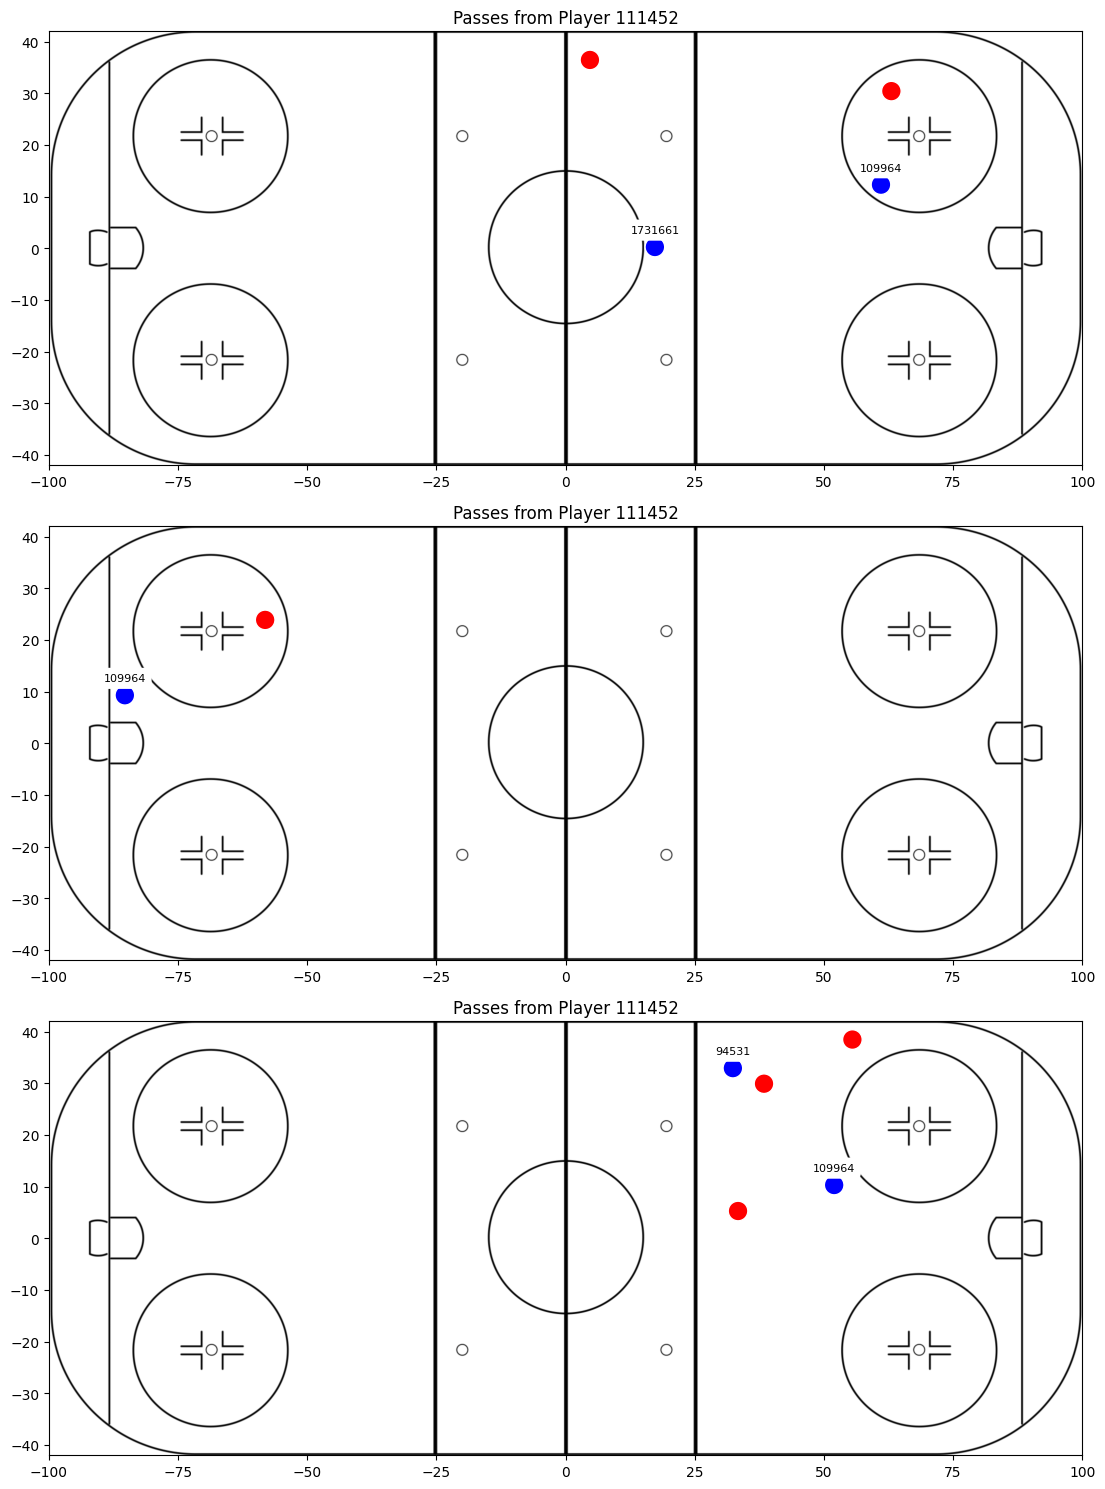

In [2126]:

fig, axs = plt.subplots(3, 1, figsize=(15, 15))  # Adjust size as needed

# List of periods and titles for each subplot
periods = [1, 2, 3]
titles = ["Period 1", "Period 2", "Period 3"]

for ax, period, title in zip(axs, periods, titles):
    # Filter data for the current period
    period_data = player_sequences1[player_sequences1['period'] == period]
    
    # Plot background image
    ax.imshow(img, extent=[-100, 100, -42, 42])
    
    # Assign color for plotting
    period_data['color'] = 'blue'  # Assign blue as the default color
    period_data.loc[period_data['playerid'] == 111452, 'color'] = 'red'

    # Plot scatter points
    ax.scatter(period_data['ovixCoords'], period_data['oviyCoords'],
               s=200, c=period_data['color'], edgecolor="white")

    for idx, row in period_data[period_data['color'] == 'blue'].iterrows():
        ax.annotate(row['playerid'], 
                    (row['ovixCoords'], row['oviyCoords']),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=8,
                    color='black',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
    
    
    # Set limits and title
    ax.set_xlim(-100, 100)
    ax.set_ylim(-42, 42)
    ax.set_title(f"Passes from Player 111452")
    

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [2164]:
player_sequences2 = shot_assists
player_sequences2=player_sequences2[['eventname', 'period', 'playerid', 'ovixCoords','oviyCoords', 'compiledgametime', 'teamid','shot_assist']]
player_sequences2

eventname  period  playerid  ovixCoords  oviyCoords  compiledgametime  \
0          pass       1    111452    2.316772    9.808823          0.733333   
1     reception       1        80   26.457947    6.791176          1.333333   
2          pass       1        80   30.481476   30.932352          2.566667   
3     reception       1    111452    3.718521   35.458824          3.166667   
4          pass       1     80264   81.171463    3.770588          5.433333   
5     reception       1     79380   67.089111   39.982353          6.333334   
6          pass       1     10534   17.297935   27.408821         11.233334   
7     reception       1    400162   51.497932   32.944118         14.333333   
8          pass       1    400162   77.650871   25.902941         15.466666   
9     reception       1     79380   85.697929   23.888237         16.666666   
10         pass       1     79380   80.165581   33.444115         17.966667   
11    reception       1     81408   15.789108   36.464706         19.000000   
12         pass       1     94531   36.904778   39.479408         24.233334   
13    reception       1    109964   98.263603    5.785294         27.366667   
14         pass       1    109964   81.163605   36.964706         29.566668   
15    reception       1     94531   27.851837   37.467644         30.633333   
16         shot       1     94531   30.869484   36.964706         30.733334   
17         pass       1    400162   96.754776   24.894119         36.233334   
18         pass       1    370192   96.754799   12.823500         38.033333   
19    reception       1    109964   77.643013   15.338234         38.400000   
20         shot       1    109964   80.157722   13.326469         38.633335   
21         pass       1    237838   92.351105   25.400000         48.433334   
22         pass       1  20775372   50.606979   36.967648         50.033333   
23    reception       1    126723   73.742279   39.482353         50.500000   
24         pass       1      6588   84.304047   36.464706         54.366665   
25    reception       1    111452   65.695221   40.488235         54.966667   
26         pass       1    111452   65.695221   39.985294         56.266666   
27    reception       1    237838   52.618744   35.961765         56.866665   
28         pass       1    237838   24.454041   26.908823         58.233334   
29         pass       1  20775372    8.237129   40.991177         59.766666   
30         pass       1    446706   94.865814   29.423531         67.333336   
31    reception       1    108339   95.368744   20.367645         68.500000   
32         pass       1     56711   81.278503   35.961800         76.466670   
33         shot       1       884   81.278534   22.379410         79.433334   
34         pass       1     56711   40.037399   38.476501         82.200000   
35         pass       1    179172   93.852066   28.920588         85.733330   
36         pass       1    446706   98.386398    2.264706         87.366670   
37         pass       1    108339   87.321686   32.441177         90.900000   
38    reception       1    110409   62.174637   29.423531         91.400000   
39         pass       1    110409   60.665802   31.435293         92.366670   
40         pass       1    179172   44.060902   29.423500         93.133330   
41         pass       1     56711   14.783226   37.973530         98.333336   
42    reception       1     54915   15.393242   14.835293         99.266670   
43         pass       1     54915    9.357948    9.805882         99.766670   
44    reception       1    179172    4.328537   15.338234        100.566666   
45         pass       1    108339   95.368744   12.823528        105.866670   
46    reception       1    113401   55.133453   38.473526        107.200000   
47         pass       1    113401   26.968750   14.835293        108.533330   
48    reception       1      1462   17.915810    8.799999        109.100000   
49         shot       1      1462   39.922428   10.30882

In [2172]:
# Initialize a list to store the results
time_differences = []

# Iterate through the DataFrame to find 'reception' events
for idx, reception_row in shot_assists[shot_assists['eventname'] == 'reception'].iterrows():
    reception_time = reception_row['compiledgametime']
    reception_period = reception_row['period']
    reception_player = reception_row['playerid']
    reception_team = reception_row['teamid']
    
    # Find the immediately following 'shot' event
    following_events = shot_assists[(shot_assists['period'] == reception_period) &
                                    (shot_assists['compiledgametime'] > reception_time)]
    following_shots = following_events[following_events['eventname'] == 'shot']
    
    if not following_shots.empty:
        # Take the first 'shot' event after the 'reception'
        shot_row = following_shots.iloc[0]
        shot_time = shot_row['compiledgametime']
        
        # Ensure the shot is by the same player and team
        if shot_row['playerid'] == reception_player and shot_row['teamid'] == reception_team:
            time_diff = (shot_time - reception_time)
            time_differences.append({
                'playerid': reception_player,
                'period': reception_period,
                'reception_time': reception_time,
                'shot_time': shot_time,
                'time_diff_seconds': time_diff
            })

# Convert results to a DataFrame
shot_time = pd.DataFrame(time_differences)

# Count the number of shots per player
shot_counts = shot_time['playerid'].value_counts()

# Filter players with more than one shot
multi_shot_players = shot_counts[shot_counts > 1].index

# Filter the original DataFrame to include only these players
multi_shots = shot_time[shot_time['playerid'].isin(multi_shot_players)]


multi_shots

playerid  period  reception_time    shot_time  time_diff_seconds
0       94531       1       30.633333    30.733334           0.100001
1      109964       1       38.400000    38.633335           0.233335
3      109964       1      130.400000   131.700000           1.300000
4    20775372       1      145.200000   146.366670           1.166670
5    20775372       1      167.900000   186.566670          18.666670
6    20775372       1      186.533340   186.566670           0.033330
7       81408       1      236.900000   236.933330           0.033330
8      111452       1      348.800000   377.300000          28.500000
9      111452       1      361.933320   377.300000          15.366680
10     111452       1      365.266660   377.300000          12.033340
11     111452       1      377.266660   377.300000           0.033340
12       5814       1      392.366670   424.066680          31.700010
13       5814       1      421.966670   424.066680           2.100010
14       6588       1      428.966670   429.000000           0.033330
15      79380       1      629.433350   639.800000          10.366650
16     112050       1      734.466700   741.033300           6.566600
17    1731661       1      825.633360   827.566650           1.933290
18      79380       1      878.366640   879.600000           1.233360
19      81408       1      895.800000   895.833300           0.033300
20      79380       1      912.700000   952.600000          39.900000
21      79380       1      928.933350   952.600000          23.666650
22      79380       1      934.033300   952.600000          18.566700
23      79380       1      950.833300   952.600000           1.766700
24      81408       1      981.166700   981.266660           0.099960
25     126723       1      985.633360   995.800000          10.166640
26     126723       1      995.766660   995.800000           0.033340
27     109964       1     1060.700000  1072.433300          11.733300
28     109964       1     1063.000000  1072.433300           9.433300
29     109964       1     1072.400000  1072.433300           0.033300
30     111452       1     1077.866700  1079.000000           1.133300
31       6588       1     1085.833400  1093.633300           7.799900
32       6588       1     1089.733300  1093.633300           3.900000
33       6588       1     1093.433300  1093.633300           0.200000
34     111452       1     1110.800000  1120.566700           9.766700
35     111452       1     1120.533300  1120.566700           0.033400
36       6588       1     1124.600000  1124.633300           0.033300
37     112050       1     1150.666600  1194.166600          43.500000
38     112050       1     1185.100000  1194.166600           9.066600
39     109964       2     1208.066700  1208.200000           0.133300
40     179172       2     1216.666600  1216.733300           0.066700
41      94531       2     1278.033300  1285.066700           7.033400
42      94531       2     1283.700000  1285.066700           1.366700
43      82048       2     1326.400000  1326.466700           0.066700
44     370192       2     1369.566700  1369.600000           0.033300
46     112050       2     1416.933300  1427.666600          10.733300
47     112050       2     1427.633300  1427.666600           0.033300
48      94531       2     1437.633300  1440.433300           2.800000
49     370192       2     1457.433300  1469.566700          12.133400
50     370192       2     1463.566700  1469.566700           6.000000
51     370192       2     1468.633300  1469.566700           0.933400
52     370192       2     1482.966700  1489.166600           6.199900
53     370192       2     1488.033300  1489.166600           1.133300
54      94531       2     1501.666600  1501.766700           0.100100
55      80518       2     1597.400000  1649.933300          52.533300
56      80518       2     1604.600000  1649.933300          45.333300
57      80518       2     1626.133300  1649.933300          23.800000
58      80518  

In [2178]:
multi_shot_times = shot_time.groupby('playerid')['time_diff_seconds'].mean()
print(multi_shot_times.max())
print(multi_shot_times.idxmax())

19.073295999999754
126723


In [2180]:
battle_data = pd.merge(event_data, xG_data, on=['compiledgametime', 'playerid'], how='inner')
battle_data.head()

eventname     outcome            type  compiledgametime         playsection  \
0      shot      failed  outsideblocked         30.733334           westPoint   
1      shot  successful         outside         38.633335    outsideNorthWest   
2      shot      failed         outside         79.433334    outsideNorthEast   
3      pass      failed           north         82.200000           westPoint   
4      pass  successful          outlet         90.900000  outsideNorthWestDZ   

  zone manpowersituation  goal  teamid  playerid  opposingteamgoalieoniceid  \
0   oz      evenStrength     0     311     94531                      80264   
1   oz      evenStrength     1     311    109964                      80264   
2   oz      evenStrength     0     315       884                       5152   
3   oz      evenStrength     0     315     56711                       5152   
4   dz      evenStrength     0     311    108339                      80264   

   xadjcoord  yadjcoord  minutes  period     xCoord     yCoord        xg  
0  30.869484 -36.964706     0.51       1 -30.869484 -36.964706  0.002939  
1  80.157722 -13.326469     0.64       1 -80.157722 -13.326469  0.072824  
2  81.278534  22.379410     1.32       1  81.278534  22.379410  0.037817  
3  40.037399 -38.476501     1.37       1  40.037399 -38.476501  0.252678  
4 -87.321686  32.441177     1.52       1 -87.321686  32.441177  0.392448

In [2182]:
battle_data = battle_data.groupby('teamid')['xg'].sum()
battle_data = pd.DataFrame(battle_data).reset_index()
battle_data



teamid        xg
0     311  5.153972
1     315  4.099661

In [2320]:
model_df = pd.merge(event_data, xG_data, on=['compiledgametime', 'playerid'], how='inner')
#If it is the case that the player is Ovi, to ensure that the y coordinates are properly unfolded:

def reverse_adjust_coordinates(row):
    x_adjusted = row['xadjcoord']
    y_adjusted = row['yadjcoord']
    
    team_id = row['teamid']  # Team ID
    period = row['period']    # Period
            
    if period in [1,3]:
        if x_adjusted < 0:
            original_x = abs(x_adjusted) #if adjusted is negative, make it positive
            original_y = abs(y_adjusted)
        else:
            original_x = x_adjusted #if adjusted is positive, use it
            original_y = abs(y_adjusted)
    else:#2nd period and OT
        if x_adjusted <0:
            original_x = x_adjusted #if adjusted is negative, use it
            original_y = y_adjusted
        else:
            original_x = -x_adjusted #if adjusted is positive , make it negative
            original_y = y_adjusted
    
    return pd.Series({'ovixCoords': original_x, 'oviyCoords': original_y})

# Example usage with a DataFrame
# Assuming you have a DataFrame `df` with adjusted coordinates and additional columns
original_coords = model_df.apply(reverse_adjust_coordinates, axis=1)

# Merge the original coordinates back to the original DataFrame if needed
model_df = model_df.join(original_coords)

#create distance calculation for each event
#center net
net_x = 89
net_y = 0

def calculate_distance(x, y, net_x=net_x, net_y=net_y):
    return math.sqrt((x - net_x)**2 + (y - net_y)**2)

# Apply the function to each row and create a new column
model_df['distance'] = model_df.apply(lambda row: calculate_distance(row['ovixCoords'], row['oviyCoords']), axis=1)


In [2321]:
model_df=model_df[['teamid','goal','distance', 'manpowersituation', 'playsection','outcome','zone','period']]
model_df['period']= model_df['period'].astype(str)
model_df.head()

teamid  goal   distance manpowersituation         playsection     outcome  \
0     311     0  68.887926      evenStrength           westPoint      failed   
1     311     1  15.993144      evenStrength    outsideNorthWest  successful   
2     315     0  23.674016      evenStrength    outsideNorthEast      failed   
3     315     0  62.271803      evenStrength           westPoint      failed   
4     311     0  32.484561      evenStrength  outsideNorthWestDZ  successful   

  zone period  
0   oz      1  
1   oz      1  
2   oz      1  
3   oz      1  
4   dz      1

In [2322]:
model_311 = model_df.query('teamid == 311')
model_315 = model_df.query('teamid == 315')

In [2307]:
from sklearn.model_selection import train_test_split

X = model_df[['distance', 'manpowersituation', 'playsection', 'outcome',
       'zone', 'period']]
y = model_df['goal']  # Binary outcome (1 if goal, 0 otherwise)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2326]:
formula = 'goal ~ distance + manpowersituation + playsection + outcome + zone + period'
model = smf.ols(formula=formula, data=model_311).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   goal   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                 -0.227
Method:                 Least Squares   F-statistic:                    0.3668
Date:                Sun, 04 Aug 2024   Prob (F-statistic):              0.990
Time:                        07:58:23   Log-Likelihood:                 14.545
No. Observations:                  66   AIC:                             10.91
Df Residuals:                      46   BIC:                             54.70
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [2309]:
## Define the coefficients
Intercept =  -0.0184
powerPlay = -0.0432      
shortHanded = -0.0929            
eastOuterSlot = -0.0224
eastPoint = -0.0678
eastPointDZ = -0.0253 
innerSlot =  0.0366           
northCenterNZ = -0.1515     
northEastBoardsNZ = -0.0270       
outsideNorthEast = -0.0576
outsideNorthEastDZ = -0.1056
outsideNorthWest = 0.1018
outsideNorthWestDZ = -0.1054
westOuterSlot = -0.0237
westOuterSlotDZ = -0.1321
westPoint =  -0.0555
successful = 0.1259
oz = 0.0742
period2 = 0.1629
period3=-0.0548
period4 = 0.2051
distance = -0.0017

dummy_df = model_df[['manpowersituation', 'playsection', 'outcome','zone','period']]
dummies = pd.get_dummies(dummy_df,dtype=int)

model_df = pd.concat([model_df, dummies], axis=1)

model_df = model_df.drop(['outcome', 'manpowersituation','playsection','zone','period'], axis=1)

model_df


teamid  goal    distance  manpowersituation_evenStrength  \
0       311     0   68.887926                               1   
1       311     1   15.993144                               1   
2       315     0   23.674016                               1   
3       315     0   62.271803                               1   
4       311     0   32.484561                               1   
5       311     0   50.148578                               1   
6       311     0   70.063423                               1   
7       315     0   69.114257                               1   
8       311     0   34.707996                               1   
9       315     0   32.861630                               1   
10      315     0   40.677249                               0   
11      315     0   49.927198                               0   
12      315     0   35.493383                               0   
13      315     0   47.336653                               0   
14      311     0   59.271573                               0   
15      311     0   43.207003                               0   
16      311     0   29.578168                               0   
17      311     0   39.529784                               0   
18      311     0   63.879473                               0   
19      315     0   28.966209                               1   
20      315     0   30.987823                               1   
21      315     0   34.271398                               1   
22      315     1   31.627626                               1   
23      311     0   51.812934                               1   
24      311     0   32.763957                               1   
25      315     0   48.397672                               1   
26      315     0   37.402585                               1   
27      315     0   40.624243                               0   
28      315     0   58.773077                               0   
29      311     0   39.441593                               0   
30      315     0   36.936736                               0   
31      315     0   10.312915                               0   
32      311     0   28.845308                               0   
33      311     0   22.785185                               0   
34      311     0   47.916663                               0   
35      311     0    9.738824                               0   
36      311     0   34.020653                               0   
37      311     0   48.391592                               0   
38      311     0  171.461664                               1   
39      315     0  165.807329                               1   
40      311     0  128.169398                               1   
41      315     0  157.659468                               1   
42      311     0  155.397405                               1   
43      311     0  136.997080                               1   
44      315     0  127.557547                               1   
45      311     0  158.723742                               0   
46      311     0  125.133242                               0   
47      311     0  152.474186                               0   
48      311     0  157.185390                               0   
49      311     0  122.395643                               0   
50      315     0  170.915379                               0   
51      315     1  136.400867                               0   
52      315     0  158.844938                               0   
53      315     0  140.014431                               0   
54      315     0  134.508479                               0   
55      315     0  137.890303                               1   
56      315     0  128.601043                               1   
57      315     0  167.223942                               1   
58      311     0  152.720167                               0   
59      311     0  157.651752                               0   
60      311     0  176.386385           

In [2310]:
model_df.columns

Index(['teamid', 'goal', 'distance', 'manpowersituation_evenStrength',
       'manpowersituation_powerPlay', 'manpowersituation_shortHanded',
       'playsection_centerPoint', 'playsection_eastOuterSlot',
       'playsection_eastPoint', 'playsection_eastPointDZ',
       'playsection_innerSlot', 'playsection_northCenterNZ',
       'playsection_northEastBoardsNZ', 'playsection_outsideNorthEast',
       'playsection_outsideNorthEastDZ', 'playsection_outsideNorthWest',
       'playsection_outsideNorthWestDZ', 'playsection_westOuterSlot',
       'playsection_westOuterSlotDZ', 'playsection_westPoint',
       'outcome_failed', 'outcome_successful', 'zone_dz', 'zone_oz',
       'period_1', 'period_2', 'period_3', 'period_4'],
      dtype='object')

In [2318]:
model_df['Predicted_Goals'] = (
    Intercept +
    (powerPlay * model_df['manpowersituation_powerPlay']) +
    (shortHanded * model_df['manpowersituation_shortHanded']) +
    (eastOuterSlot * model_df['playsection_eastOuterSlot']) +
    (eastPoint * model_df['playsection_eastPoint']) +
    (innerSlot * model_df['playsection_innerSlot']) +
    (northCenterNZ * model_df['playsection_northCenterNZ']) +
    (northEastBoardsNZ * model_df['playsection_northEastBoardsNZ']) +
    (outsideNorthEast * model_df['playsection_outsideNorthEast']) +
    (outsideNorthEastDZ * model_df['playsection_outsideNorthEastDZ']) +
    (outsideNorthWest * model_df['playsection_outsideNorthWest']) +
    (outsideNorthWestDZ * model_df['playsection_outsideNorthWestDZ']) +
    (westOuterSlotDZ * model_df['playsection_westOuterSlotDZ']) +
    (westPoint * model_df['playsection_westPoint']) +
    (successful * model_df['outcome_successful']) +
    (oz * model_df['zone_oz'])+
    (distance * model_df['distance']) +
    (period2 * model_df['period_2'])+
    (period3 * model_df['period_3'])+
    (period4 * model_df['period_4'])
    )


model_df['Predicted_Goals'] = round(model_df['Predicted_Goals'],2)
model_df

teamid  goal    distance  manpowersituation_evenStrength  \
0       311     0   68.887926                               1   
1       311     1   15.993144                               1   
2       315     0   23.674016                               1   
3       315     0   62.271803                               1   
4       311     0   32.484561                               1   
5       311     0   50.148578                               1   
6       311     0   70.063423                               1   
7       315     0   69.114257                               1   
8       311     0   34.707996                               1   
9       315     0   32.861630                               1   
10      315     0   40.677249                               0   
11      315     0   49.927198                               0   
12      315     0   35.493383                               0   
13      315     0   47.336653                               0   
14      311     0   59.271573                               0   
15      311     0   43.207003                               0   
16      311     0   29.578168                               0   
17      311     0   39.529784                               0   
18      311     0   63.879473                               0   
19      315     0   28.966209                               1   
20      315     0   30.987823                               1   
21      315     0   34.271398                               1   
22      315     1   31.627626                               1   
23      311     0   51.812934                               1   
24      311     0   32.763957                               1   
25      315     0   48.397672                               1   
26      315     0   37.402585                               1   
27      315     0   40.624243                               0   
28      315     0   58.773077                               0   
29      311     0   39.441593                               0   
30      315     0   36.936736                               0   
31      315     0   10.312915                               0   
32      311     0   28.845308                               0   
33      311     0   22.785185                               0   
34      311     0   47.916663                               0   
35      311     0    9.738824                               0   
36      311     0   34.020653                               0   
37      311     0   48.391592                               0   
38      311     0  171.461664                               1   
39      315     0  165.807329                               1   
40      311     0  128.169398                               1   
41      315     0  157.659468                               1   
42      311     0  155.397405                               1   
43      311     0  136.997080                               1   
44      315     0  127.557547                               1   
45      311     0  158.723742                               0   
46      311     0  125.133242                               0   
47      311     0  152.474186                               0   
48      311     0  157.185390                               0   
49      311     0  122.395643                               0   
50      315     0  170.915379                               0   
51      315     1  136.400867                               0   
52      315     0  158.844938                               0   
53      315     0  140.014431                               0   
54      315     0  134.508479                               0   
55      315     0  137.890303                               1   
56      315     0  128.601043                               1   
57      315     0  167.223942                               1   
58      311     0  152.720167                               0   
59      311     0  157.651752                               0   
60      311     0  176.386385           